In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
warnings.filterwarnings('ignore')

In [2]:
KEY = "98464488-2db9-4ddc-9b98-6b48f8b623dc" # do not change
LIMIT = 365
COIN = 'BTC'

In [3]:
def prices(product_id, period=30, granularity=86400, start=None, end=None):
    """
    Fetch historical candlestick data for a cryptocurrency pair from now to the specified number of days in the past.

    :param product_id: The product ID for the crypto pair (e.g., 'BTC-USD').
    :param period: Number of days of historical data to fetch.
    :param granularity: Desired time slice in seconds (60, 300, 900, 3600, 21600, 86400).
    :return: DataFrame containing historical data.
    """
    if not product_id.endswith('-USD'):
        product_id += '-USD'
    product_id = product_id.upper()
    url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"
    if start is None and end is None: # get data from specified number of days ago if date bounds are not specified.
        end = datetime.now()
        start = end - timedelta(days=period)
    coin = product_id.split('-')[0]
    all_data = []

    while start < end:
        end_slice = min(start + timedelta(seconds=granularity * 300), end)
        params = {
            'start': start.isoformat(),
            'end': end_slice.isoformat(),
            'granularity': granularity
        }

        try:
            response = requests.get(url, params=params)
        except ConnectionError:
            print("No internet connection")
            return None, coin
        except ReadTimeoutError:
            print('Your wifi likely doesn\'t allow to access Coinbase API')
            return None, coin

        if response.status_code == 200:
            data = response.json()
            all_data.extend(data)
        else:
            print("Failed to fetch data:", response.text)
            break

        start = end_slice

    if all_data:
        columns = ['time', 'low', 'high', 'open', 'close', 'volume']
        data = pd.DataFrame(all_data, columns=columns)
        data['time'] = pd.to_datetime(data['time'], unit='s')
        data['change'] = data['close'] - data['open']
        data['pct_change'] = (data['change'] / data['open']) * 100
        return data, coin
    return None, coin

In [4]:
df, coin = prices(COIN, period=365)

In [5]:
df

,time,low,high,open,close,volume,change,pct_change
0,2025-04-04,81643.54,84720.67,83178.68,83860.16,14593.030929,681.48,0.819296
1,2025-04-03,81177.70,83953.45,82490.10,83174.33,11800.911066,684.23,0.829469
2,2025-04-02,82283.01,88530.00,85166.92,82490.08,16748.282623,-2676.84,-3.143051
3,2025-04-01,82403.32,85566.53,82534.31,85170.37,9130.976926,2636.06,3.193896
4,2025-03-31,81265.16,83920.80,82379.98,82534.32,6887.946942,154.34,0.187351
...,...,...,...,...,...,...,...,...
360,2025-04-09,74553.01,83583.35,76258.80,82594.75,23584.944641,6335.95,8.308484
361,2025-04-08,76167.35,80849.98,79140.02,76251.64,14917.023517,-2888.38,-3.649708
362,2025-04-07,74420.69,81223.67,78370.15,79140.01,26706.529308,769.86,0.982338
363,2025-04-06,77058.99,83773.58,83505.88,78370.75,11014.859477,-5135.13,-6.149423


## Find the FGI change and close price change correlation

Do this for all the coins

In [6]:
def get_fgi_data():
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
      fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')
      return fgi_df
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

In [7]:
def fgi_close_association(coin='BTC'):
  try:
    coinPrices, i = prices(coin, period=LIMIT)
  except:
    print('Invalid coin: ', coin)
    print('Period: ', LIMIT)
    return None
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

  # convert timestamp to date
  fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')

  # inner join the prices on the timestamp
  everything = pd.merge(coinPrices, fgi_df, left_on='time', right_on='timestamp', how='inner')
  everything = pd.get_dummies(everything)

  # create pct_change for the fgi value
  everything['fgi_pct_change'] = everything['value'].pct_change()
  everything['fgi_pct_change'].fillna(0, inplace=True)
  everything['pct_change'].fillna(0, inplace=True)
  correlation = everything.corr()
  item1 = correlation['pct_change']['fgi_pct_change']
  item2 = np.sqrt(mean_squared_error(everything['pct_change'], everything['fgi_pct_change']))
  return {
      'coin': coin,
      'correlation': item1,
      'RMSE': item2
  }

In [8]:
get_fgi_data()

,timestamp,value,value_classification
0,2025-06-07,52,Neutral
1,2025-06-06,46,Neutral
2,2025-06-05,55,Neutral
3,2025-06-04,57,Neutral
4,2025-06-03,58,Neutral
...,...,...,...
360,2024-06-12,56,Neutral
361,2024-06-11,60,Greed
362,2024-06-10,61,Greed
363,2024-06-09,61,Greed


In [9]:
coins = ['BTC', 'NEAR', 'ETH', 'AVAX', 'SOL', 'ICP', 'FET']
correlations = [fgi_close_association(coin) for coin in coins]
everything = pd.DataFrame(correlations).sort_values(by='RMSE', ascending=True)

In [10]:
import altair as alt

# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('RMSE')

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='RMSE'
).properties(
    title='RMSE by Coin'  # Add a title to the chart
)

alt.Chart(...)

In [11]:
# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('correlation')
everything_sorted['abs_correlation'] = np.abs(everything_sorted['correlation'])

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='abs_correlation'
).properties(
    title='Correlation Magnitude by Coin'  # Add a title to the chart
)

alt.Chart(...)

## Crypto market collector

In [12]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Constants

# -------------------------------
# 1. Market-Faceted Metrics
# -------------------------------

def get_global_market_data():
    """
    Fetch overall market data such as total market capitalization, trading volume, and Bitcoin dominance.
    Purpose: Helps understand the overall health and activity of the cryptocurrency market.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return {
            'total_market_cap': data['data']['quote']['USD']['total_market_cap'],
            'total_volume_24h': data['data']['quote']['USD']['total_volume_24h'],
            'btc_dominance': data['data']['btc_dominance'],
            'active_cryptocurrencies': data['data']['active_cryptocurrencies']
        }
    else:
        print(f"Failed to fetch global market data: {response.status_code}")
        return None

def get_tokenomics(coin):
    """
    Fetch tokenomics data such as circulating supply and total supply.
    Purpose: Helps understand the supply dynamics of a coin, which can influence its price.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/cryptocurrency/info"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    params = {
        'symbol': coin
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        supply_data = data['data'][coin]
        return supply_data
    else:
        print(f"Failed to fetch tokenomics for {coin}: {response.status_code}")
        return None

# -------------------------------
# Additional Metrics
# -------------------------------


# Example Usage
if __name__ == "__main__":
    # Fetch global market data
    market_data = get_global_market_data()
    print("Market Data:", market_data)

    # Fetch tokenomics data
    tokenomics_data = get_tokenomics('BTC')
    print("Tokenomics:", tokenomics_data)


Market Data: {'total_market_cap': 3322454147466.623, 'total_volume_24h': 84183405787.45, 'btc_dominance': 63.620251976791, 'active_cryptocurrencies': 9725}
Tokenomics: {'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'category': 'coin', 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,876,171. The last known price of Bitcoin is 106,347.72391644 USD and is up 0.54 over the last 24 hours. It is currently trading on 12210 active market(s) with $36,292,370,130.25 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'slug': 'bitcoin', 'logo': 'https://s2.coinmarketcap.com/static/img/coins/64x64/1.png', 'subreddit': 'bitcoin', 'notice': '', 'tags': ['mineable', 'pow', 'sha-256', 'store-of-value', 'state-channel', 'coinbase-ventures-portfolio', 'three-arrows-capital-portfolio', 'polychain-capital-portfolio', 'binance-labs-portfolio', 'blockchain-c

In [13]:
pd.json_normalize(tokenomics_data)

,id,name,symbol,category,description,slug,logo,subreddit,notice,tags,...,urls.website,urls.twitter,urls.message_board,urls.chat,urls.facebook,urls.explorer,urls.reddit,urls.technical_doc,urls.source_code,urls.announcement
0,1,Bitcoin,BTC,coin,Bitcoin (BTC) is a cryptocurrency launched in ...,bitcoin,https://s2.coinmarketcap.com/static/img/coins/...,bitcoin,,"[mineable, pow, sha-256, store-of-value, state...",...,[https://bitcoin.org/],[],[https://bitcointalk.org],[],[],"[https://blockchain.info/, https://live.blockc...",[https://reddit.com/r/bitcoin],[https://bitcoin.org/bitcoin.pdf],[https://github.com/bitcoin/bitcoin],[]


In [14]:
pd.json_normalize(market_data)

,total_market_cap,total_volume_24h,btc_dominance,active_cryptocurrencies
0,3.322454e+12,8.418341e+10,63.620252,9725


# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [15]:
import pandas as pd
import numpy as np

# Assume you have already fetched data using your prices() function,
# and that your DataFrame (df) has at least the following columns:
# ['time', 'low', 'high', 'open', 'close', 'volume']

# ----------------------------
# 1. Moving Averages (SMA & EMA)
# ----------------------------
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ----------------------------
# 2. Relative Strength Index (RSI)
# ----------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    # Separate positive and negative gains
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Simple moving average over 'window' periods for gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Alternatively, one can use exponential weighting:
    # avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    # avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['close'], window=14)

# ----------------------------
# 3. Moving Average Convergence Divergence (MACD)
# ----------------------------
# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD line: difference between the 12-EMA and 26-EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line: 9-period EMA of the MACD line
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram: the difference between MACD and its signal line
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# ----------------------------
# 4. Bollinger Bands
# ----------------------------
# Bollinger Bands are typically computed using a moving average and standard deviation.
# Here we use the 20-period SMA (which we already computed) and a factor of 2 standard deviations.
df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']

# Optionally, you can drop the intermediate 'BB_STD' column later if not needed:
# df.drop(columns=['BB_STD'], inplace=True)

# ----------------------------
# 5. Volume Indicators
# ----------------------------
# Example 1: 20-period moving average of volume (helps smooth out spikes)
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

# Example 2: On-Balance Volume (OBV)
# OBV is designed to relate volume flow to price change.
# We'll start OBV at zero and add/subtract volume depending on price movement.
df['daily_return'] = df['close'].pct_change()  # percentage change in closing price
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)  # +1 for up days, -1 for down days
df.loc[df['daily_return'].isna(), 'direction'] = 0  # set initial value to 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()

# Clean up temporary columns
df.drop(columns=['daily_return', 'direction'], inplace=True)

# ----------------------------
# View the final DataFrame with the newly computed technical indicators
# ----------------------------
df.tail()

# If you wish to inspect or plot these indicators (for example, overlaying Bollinger Bands on price),
# you can use matplotlib, seaborn, or a plotting library of your choice.

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,EMA_26,MACD,MACD_Signal,MACD_Hist,BB_Middle,BB_STD,BB_Upper,BB_Lower,Volume_MA_20,OBV
360,2025-04-09,74553.01,83583.35,76258.80,82594.75,23584.944641,6335.95,8.308484,87671.6945,96821.2086,...,88542.703755,-3837.061308,-3594.794606,-242.266702,87671.6945,5141.153634,97954.001768,77389.387232,8322.390593,-261566.847156
361,2025-04-08,76167.35,80849.98,79140.02,76251.64,14917.023517,-2888.38,-3.649708,86732.1480,96189.8556,...,87632.254588,-4227.227902,-3721.281265,-505.946637,86732.1480,5432.023175,97596.194350,75868.101650,8700.853217,-276483.870673
362,2025-04-07,74420.69,81223.67,78370.15,79140.01,26706.529308,769.86,0.982338,86000.1200,95593.0866,...,87003.199433,-4254.329161,-3827.890844,-426.438316,86000.1200,5418.650281,96837.420563,75162.819437,9920.932788,-249777.341365
363,2025-04-06,77058.99,83773.58,83505.88,78370.75,11014.859477,-5135.13,-6.149423,85185.3255,94971.2152,...,86363.758734,-4288.445427,-3920.001761,-368.443666,85185.3255,5270.047252,95725.420004,74645.230996,10358.976290,-260792.200842
364,2025-04-05,82346.61,84238.35,83859.78,83498.25,2836.429207,-361.53,-0.431113,84624.7985,94460.2066,...,86151.498828,-3857.272183,-3907.455845,50.183662,84624.7985,4776.921493,94178.641486,75070.955514,9793.430061,-257955.771635


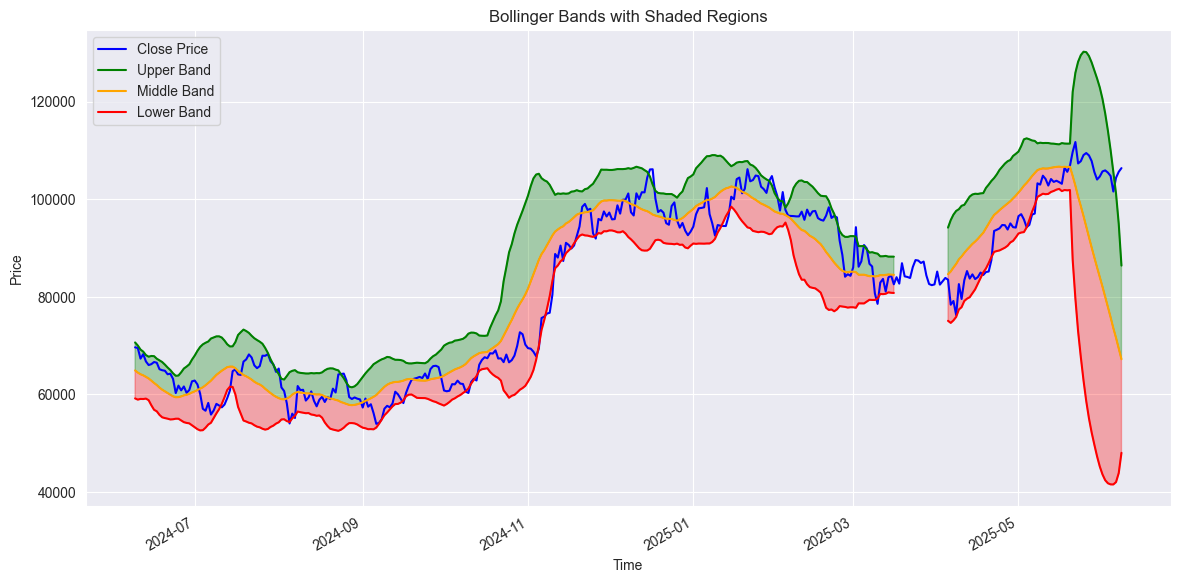

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the DataFrame is sorted by time
df = df.sort_values('time').reset_index(drop=True)

# Optionally drop rows with NaNs in Bollinger Bands, if any (depends on your data)
# df = df.dropna(subset=['BB_Upper', 'BB_Middle', 'BB_Lower'])

fig, ax = plt.subplots(figsize=(14, 7))

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')

# Shade the area between the upper and middle bands
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
# Shade the area between the middle and lower bands
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

# Optional: improve formatting of x-axis dates
fig.autofmt_xdate()
plt.show()

## 1. Use bollinger bands to predict buy and sell

* Train LSTM on close price, then predict bollinger bands

Epoch 0, Train Loss: 0.8958626389503479, Val Loss: 1.2835274934768677
Epoch 10, Train Loss: 0.8713476657867432, Val Loss: 1.325028657913208
Epoch 20, Train Loss: 0.865781307220459, Val Loss: 1.3518917560577393
Epoch 30, Train Loss: 0.8572524785995483, Val Loss: 1.3144007921218872
Epoch 40, Train Loss: 0.8462285995483398, Val Loss: 1.2857390642166138
Epoch 50, Train Loss: 0.8356873989105225, Val Loss: 1.227315902709961
Epoch 60, Train Loss: 0.8287829160690308, Val Loss: 1.2106858491897583
Epoch 70, Train Loss: 0.8223783373832703, Val Loss: 1.2166407108306885
Epoch 80, Train Loss: 0.8175017237663269, Val Loss: 1.20844566822052
Epoch 90, Train Loss: 0.8124008178710938, Val Loss: 1.2107988595962524
Epoch 100, Train Loss: 0.8054298758506775, Val Loss: 1.21576726436615
Epoch 110, Train Loss: 0.7968794703483582, Val Loss: 1.2256596088409424
Epoch 120, Train Loss: 0.7868970632553101, Val Loss: 1.2433348894119263
Epoch 130, Train Loss: 0.7719998955726624, Val Loss: 1.2740256786346436
Epoch 140,

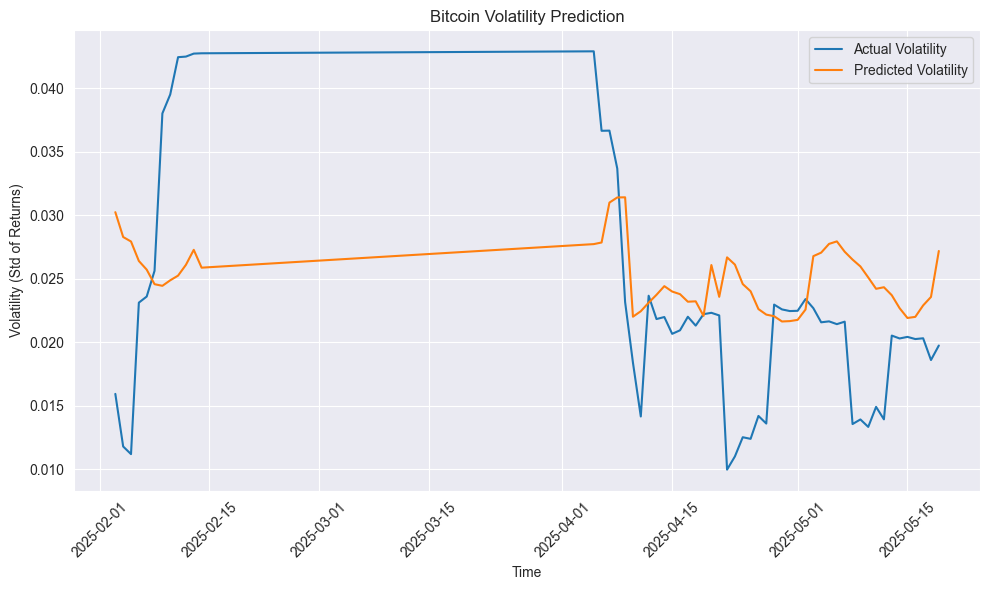

Data range: 2024-06-10 00:00:00 to 2025-05-29 00:00:00


In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'time' and 'close' columns
# Replace with your actual data loading if needed
# Example: df = pd.read_csv('bitcoin_data.csv')

# Sort by time
df = df.sort_values('time')

# Calculate daily log returns
df['returns'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()  # Remove NaN from shift

# Calculate volatility (e.g., rolling 10-day standard deviation of returns)
vol_window = 10  # Window for volatility calculation
df['volatility'] = df['returns'].rolling(window=vol_window).std().shift(-vol_window)
df = df.dropna()  # Drop NaN from rolling and shift

# Prepare data with a lookback window
lookback = 10  # Use 10 past days of returns to predict future volatility
scaler = StandardScaler()
returns_values = df['returns'].values.reshape(-1, 1)
scaled_returns = scaler.fit_transform(returns_values)

# Target: scaled volatility
vol_scaler = StandardScaler()
volatility_values = df['volatility'].values.reshape(-1, 1)
scaled_volatility = vol_scaler.fit_transform(volatility_values)

# Create sequences
X_data, y_data = [], []
for i in range(lookback, len(scaled_returns) - vol_window):
    X_data.append(scaled_returns[i-lookback:i])  # Past 'lookback' returns
    y_data.append(scaled_volatility[i])          # Volatility at current point

X_data, y_data = np.array(X_data), np.array(y_data)
X_data = X_data.reshape((X_data.shape[0], lookback, 1))  # [samples, timesteps, features]

# Split into train and test (no shuffling for time series)
train_size = int(0.8 * len(X_data))
X_train_data = X_data[:train_size]
X_test_data = X_data[train_size:]
y_train_data = y_data[:train_size]
y_test_data = y_data[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).view(-1, 1)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Output from last time step
        out = self.linear(out)
        return out

# Initialize model, loss, and optimizer
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower LR for volatility

# Training loop
model.train()
for epoch in range(150):  # More epochs for finer tuning
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_test_tensor)
            val_loss = criterion(val_output, y_test_tensor)
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')
        model.train()

# Evaluate and predict
model.eval()
with torch.no_grad():
    val_output = model(X_test_tensor)
    val_loss = criterion(val_output, y_test_tensor)
    print(f'Final Validation Loss: {val_loss.item()}')

# Inverse transform predictions for plotting
predictions = vol_scaler.inverse_transform(val_output.numpy())
actual = vol_scaler.inverse_transform(y_test_tensor.numpy())

# Align time for test set (accounting for lookback and vol_window offset)
test_times = df['time'].iloc[train_size + lookback:train_size + lookback + len(predictions)]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_times, actual, label='Actual Volatility')
plt.plot(test_times, predictions, label='Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility (Std of Returns)')
plt.title('Bitcoin Volatility Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Print min/max time for reference
print(f"Data range: {df['time'].min()} to {df['time'].max()}")

Scaled close shape: (354, 1), min: -2.3712079985097976, max: 2.8337324283407597
X_data shape: (343, 10, 1), y_data shape: (343, 1)
X_train shape: torch.Size([274, 10, 1]), y_train shape: torch.Size([274, 1])
X_test shape: torch.Size([69, 10, 1]), y_test shape: torch.Size([69, 1])
Epoch 0, Train Loss: 1.057990312576294, Val Loss: 0.728256106376648
Epoch 10, Train Loss: 1.0540964603424072, Val Loss: 0.7264643311500549
Epoch 20, Train Loss: 1.0499824285507202, Val Loss: 0.7280076742172241
Epoch 30, Train Loss: 1.047967791557312, Val Loss: 0.7319713234901428
Epoch 40, Train Loss: 1.045042872428894, Val Loss: 0.7337924838066101
Epoch 50, Train Loss: 1.0402652025222778, Val Loss: 0.7344925403594971
Epoch 60, Train Loss: 1.0324676036834717, Val Loss: 0.7348787784576416
Epoch 70, Train Loss: 1.0184301137924194, Val Loss: 0.7281143665313721
Epoch 80, Train Loss: 1.00861656665802, Val Loss: 0.7323878407478333
Epoch 90, Train Loss: 0.9923667907714844, Val Loss: 0.7321701049804688
Final Validation

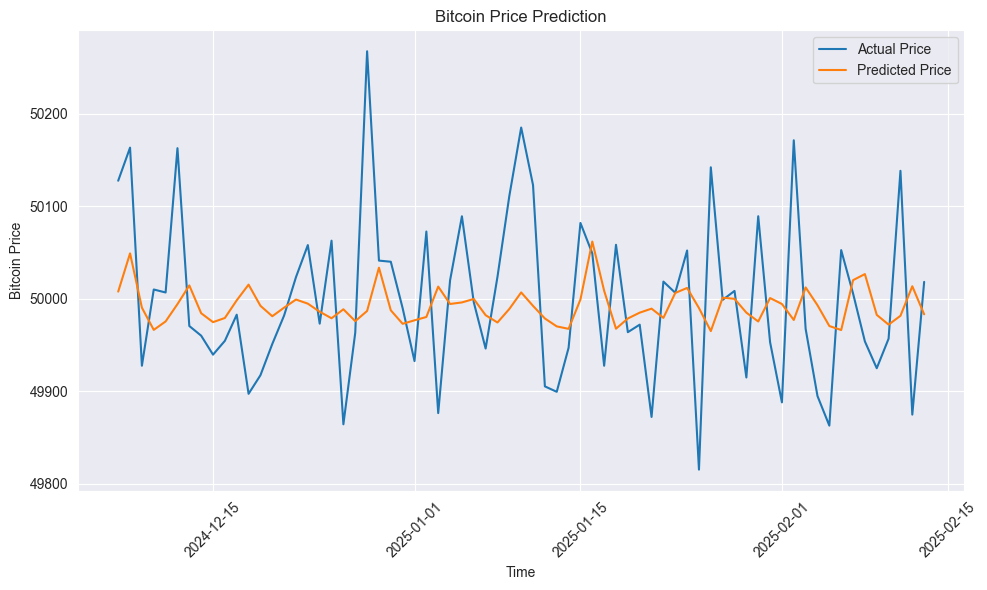

Data range: 2024-02-27 00:00:00 to 2025-02-14 00:00:00


In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Dummy data for demonstration (replace with your actual data)
dates = pd.date_range(start="2024-02-27", end="2025-02-14", freq='D')
df = pd.DataFrame({'time': dates, 'close': np.random.randn(len(dates)) * 100 + 50000})
df = df.sort_values('time')

# Prepare data with a lookback window
lookback = 10  # Use 10 past days to predict next day
scaler = StandardScaler()
close_values = df['close'].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_values)

# Debug: Check scaled data
print(f"Scaled close shape: {scaled_close.shape}, min: {scaled_close.min()}, max: {scaled_close.max()}")

# Create sequences
X_data, y_data = [], []
for i in range(lookback, len(scaled_close) - 1):
    X_data.append(scaled_close[i-lookback:i])  # Past 'lookback' days
    y_data.append(scaled_close[i])            # Next day's price

X_data, y_data = np.array(X_data), np.array(y_data)
X_data = X_data.reshape((X_data.shape[0], lookback, 1))  # [samples, timesteps, features]

# Debug: Check sequence shapes
print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")

# Split into train and test (no shuffling for time series)
train_size = int(0.8 * len(X_data))
X_train_data = X_data[:train_size]
X_test_data = X_data[train_size:]
y_train_data = y_data[:train_size]
y_test_data = y_data[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).view(-1, 1)

# Debug: Check tensor shapes
print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Output from last time step
        out = self.linear(out)
        return out

# Initialize model, loss, and optimizer
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Prevent exploding gradients
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_test_tensor)
            val_loss = criterion(val_output, y_test_tensor)
        print(f"Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")
        model.train()

# Evaluate and predict
model.eval()
with torch.no_grad():
    val_output = model(X_test_tensor)
    val_loss = criterion(val_output, y_test_tensor)
    print(f"Final Validation Loss: {val_loss.item()}")

# Inverse transform predictions for plotting
predictions = scaler.inverse_transform(val_output.numpy())
actual = scaler.inverse_transform(y_test_tensor.numpy())

# Debug: Check prediction length
print(f"Predictions length: {len(predictions)}, Actual length: {len(actual)}")

# Align time for test set (accounting for lookback offset)
test_start_idx = train_size + lookback
test_end_idx = test_start_idx + len(predictions)
if test_end_idx > len(df):
    test_end_idx = len(df)
test_times = df['time'].iloc[test_start_idx:test_end_idx]

# Debug: Check time alignment
print(f"Test times length: {len(test_times)}, df length: {len(df)}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_times, actual, label='Actual Price')
plt.plot(test_times, predictions, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print data range
print(f"Data range: {df['time'].min()} to {df['time'].max()}")

In [19]:
X_test.sort_values(by='time')


NameError: name 'X_test' is not defined

In [ ]:
X_test

In [ ]:
# @title time vs predictions

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['predictions']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_test.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('predictions')

In [ ]:
# @title time vs predictions

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_test.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('close')